In [1]:
import os
import cv2
import json
import torch
import pathlib
import numpy as np
import torchvision.utils as vutils
import torchvision.transforms as T
from matplotlib import pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from einops import rearrange
from torch import BoolTensor, FloatTensor, LongTensor
from typing import Dict, List, Optional, Tuple, Union

In [2]:
def convert_layout_to_image(
    boxes: FloatTensor,
    labels: LongTensor,
    colors: List[Tuple[int]],
    canvas_size: Optional[Tuple[int]] = None,
    resources: Optional[Dict] = None,
    names: Optional[Tuple[str]] = None,
    index: bool = False,
    **kwargs,
):
    H, W = canvas_size
    if names or index:
        font_path = os.path.join(cv2.__path__[0],'qt','fonts','DejaVuSans.ttf')
        font = ImageFont.truetype(font_path, size=32)
    if resources:
        img = resources["img_bg"].resize((W, H))
    else:
        img = Image.new("RGB", (int(W), int(H)), color=(255, 255, 255))
    draw = ImageDraw.Draw(img, "RGBA")
    
    for i in range(boxes.shape[0]):
        bbox, label = boxes[i], labels[i]
        if isinstance(label, LongTensor):
            label = label.item()

        c_fill = colors[label] + (100,)
        x1, y1, x2, y2 = bbox
        x1, x2 = x1 * (W - 1), x2 * (W - 1)
        y1, y2 = y1 * (H - 1), y2 * (H - 1)

        if resources:
            patch = resources["cropped_patches"][i]
            # round coordinates for exact size match for rendering images
            x1, x2 = int(x1), int(x2)
            y1, y2 = int(y1), int(y2)
            w, h = x2 - x1, y2 - y1
            patch = patch.resize((w, h))
            img.paste(patch, (x1, y1))
        else:
            draw.rectangle([x1, y1, x2, y2], outline=colors[label], fill=c_fill)
            if names:
                draw.text((x1, y1), names[label], "black", font=font)
            elif index:
                draw.text((x1, y1), str(int(i % (len(labels)/2))), "black", font=font)

    return img

### Dataset Information

In [3]:
json_path = './annotation_file.json'  # dataset original annotation file
category_list = json.load(open(json_path))['categories']
name_list = [category_list[idx]['name'] for idx in range(len(category_list))] # category names
name_num = len(name_list)  # category number
print(name_num)

75


### Set colors

In [4]:
COLORS = tuple([tuple(map(int,tuple((torch.rand(1,3).squeeze(0)*255).tolist()))) for _ in range(name_num)])

In [5]:
def save_image(
    batch_boxes: FloatTensor,
    batch_labels: LongTensor,
    batch_mask: BoolTensor,
    out_path: Optional[Union[pathlib.PosixPath, str]] = None,
    canvas_size: Optional[Tuple[int]] = (1600, 1600),
    nrow: Optional[int] = None,
    batch_resources: Optional[Dict] = None,
    use_grid: bool = True,
    draw_label: bool = False,
    draw_index: bool = False,
    dataset: str = 'publaynet'
):
    # batch_boxes: [B, N, 4]
    # batch_labels: [B, N]
    # batch_mask: [B, N]

    if isinstance(out_path, pathlib.PosixPath):
        out_path = str(out_path)

    colors = COLORS

    if not draw_label:
        names = None
    else:
        names = name_list

    imgs = []
    B = batch_boxes.size(0)
    to_tensor = T.ToTensor()
    for i in range(B):
        mask_i = batch_mask[i]
        boxes = batch_boxes[i][mask_i]
        labels = batch_labels[i][mask_i]
        if batch_resources:
            resources = {k: v[i] for (k, v) in batch_resources.items()}
            img = convert_layout_to_image(boxes, labels, colors, canvas_size, resources, names=names, index=draw_index)
        else:
            img = convert_layout_to_image(boxes, labels, colors, canvas_size, names=names, index=draw_index)
        imgs.append(to_tensor(img))
    image = torch.stack(imgs)

    if nrow is None:
        nrow = int(np.ceil(np.sqrt(B)))

    if out_path:
        vutils.save_image(image, out_path, normalize=False, nrow=nrow)
    else:
        if use_grid:
            return torch_to_numpy_image(
                vutils.make_grid(image, normalize=False, nrow=nrow)
            )
        else:
            return image

            
def torch_to_numpy_image(input_th: FloatTensor) -> np.ndarray:
    """
    Args
        input_th: (C, H, W), in [0.0, 1/0], torch image
    Returns
        output_npy: (H, W, C), in {0, 1, ..., 255}, numpy image
    """
    x = (input_th * 255.0).clamp(0, 255)
    x = rearrange(x, "c h w -> h w c")
    output_npy = x.numpy().astype(np.uint8)
    return output_npy

### Visualize layouts

In [6]:
layout_all = json.load(open("./generated_layouts/combined_layouts.json"))  # your generated layouts path

MAX_BBOXES_NUM = 50  # set the maximum number of elements in a single layout
batch_size = 4       # display how many layouts at a time
scale_factor = 0

base_index = [idx for idx in range(0,batch_size)]
index_all = [batch_size*(scale_factor-1)+x for x in base_index]   # layouts idx for those are displayed

batch_bbox, batch_category, batch_mask = [], [], []
for batch in range(batch_size):
    layout = layout_all[index_all[batch]]
    bbox, category = layout["boxes"], layout["categories"]
    bbox = torch.Tensor(bbox)
    real_bbox = torch.zeros(MAX_BBOXES_NUM,4)
    real_bbox[:bbox.shape[0]] = bbox
    real_category = torch.ones(MAX_BBOXES_NUM)*5
    category = torch.Tensor(category)
    real_category[:category.shape[0]] = category
    real_mask = torch.ones(MAX_BBOXES_NUM).bool()
    real_mask[bbox.shape[0]:] = False
    batch_bbox.append(real_bbox.unsqueeze(0))
    batch_category.append(real_category.unsqueeze(0))
    batch_mask.append(real_mask.unsqueeze(0))
batch_bbox = torch.cat(batch_bbox, dim=0)
batch_category = torch.cat(batch_category, dim=0).long()
batch_mask = torch.cat(batch_mask, dim=0)

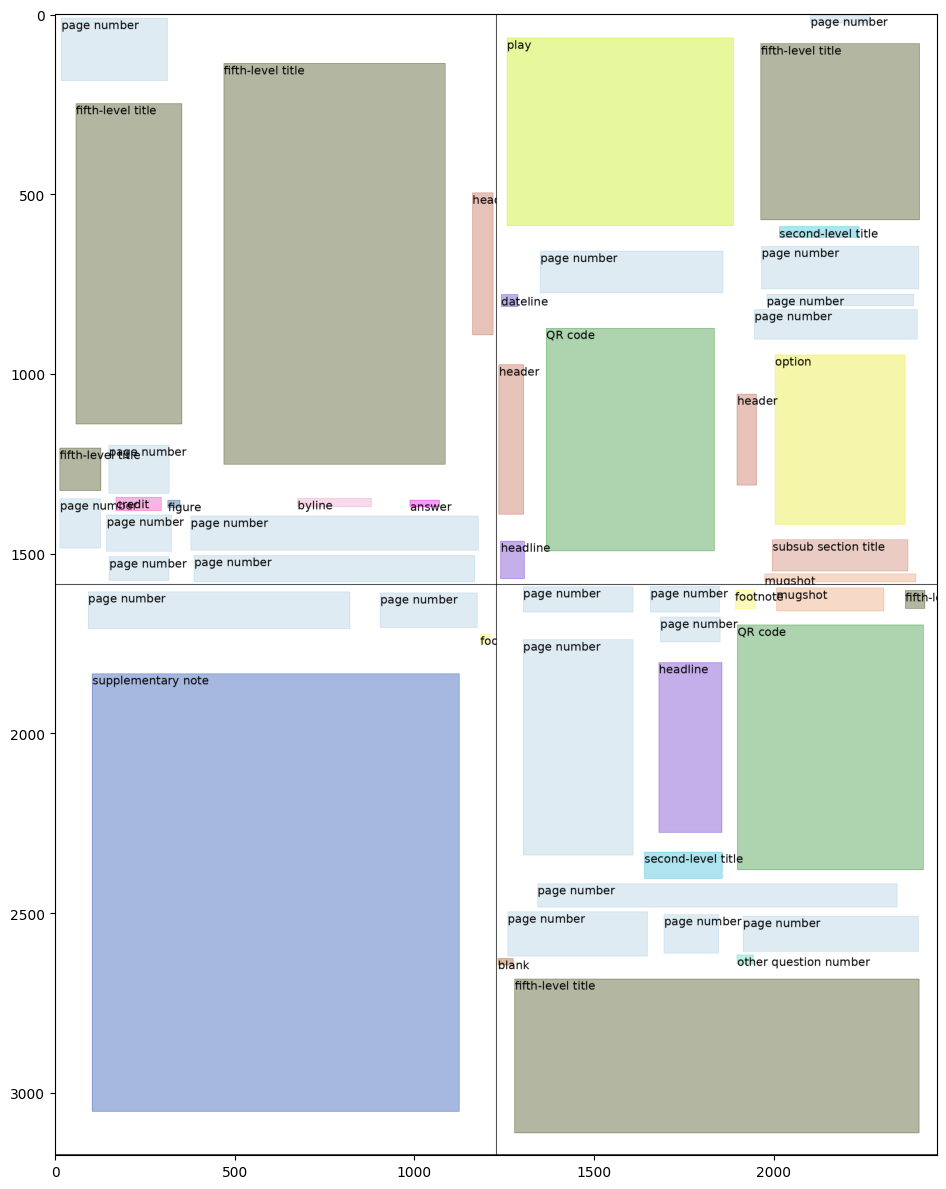

In [7]:
DRAW_LABEL = True
batch_image = save_image(batch_bbox, batch_category, batch_mask, canvas_size = (1584,1224), draw_label=DRAW_LABEL)
plt.figure(figsize=[12, 12])
plt.imshow(batch_image)
plt.tight_layout()